In [3]:
import os, sys, argparse, importlib, time, inspect
import numpy as np
import matplotlib.pyplot as plt
import os.path as osp
if hasattr(__builtins__,'__IPYTHON__'):
    print('Notebook')
    from tqdm.notebook import tqdm
else:
    print('Not notebook')
    from tqdm import tqdm
from tensorflow.keras import backend as K
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' 
import tensorflow as tf
import tensorflow_probability as tfp

# gpu_devices = tf.config.list_physical_devices('GPU') 
# if len(gpu_devices) > 0:
#     print("GPU detected")
#     tf.config.experimental.set_memory_growth(gpu_devices[0], True)
# else:
#     print('No GPU detected')

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.models import load_model, Model
import spektral
from sklearn.preprocessing import normalize
from spektral.data import DisjointLoader, BatchLoader, SingleLoader
from importlib import reload

import datetime as dt
os.chdir("..") ######!!!!!!
import data_load as dl
graph_data=dl.graph_data

Notebook
Not notebook


In [21]:
with tf.device('/cpu:0'):
    model=tf.keras.models.load_model('from_config/trained_models/IceCube/SageHop_bigrun_32wrhy9v')
    model.compile()
    batch_size=512
    dataset=graph_data(n_data=20000,skip=int(1.4e6-1), n_neighbors=14, features=["dom_x", "dom_y", "dom_z", "time", "charge_log10", "SRTInIcePulses", "lc"], graph_construction='classic_lc', restart=0)
    loader = DisjointLoader(dataset, batch_size=batch_size, epochs=1)

Loading data to memory


In [22]:
@tf.function(input_signature = loader.tf_signature(), experimental_relax_shapes = True)
def test_step(inputs, targets):
    predictions = model(inputs, training = False)
    targets     = tf.cast(targets, tf.float32) 

    return predictions, targets

In [23]:
def predict(loader):
    prediction_list, target_list = [], []
    for batch in loader:
        inputs, targets = batch
        predictions, targets = test_step(inputs, targets)

        prediction_list.append(predictions.numpy())
        target_list.append(targets.numpy())
        y_reco  = tf.concat(prediction_list, axis = 0).numpy()
        y_true  = tf.concat(target_list, axis = 0)
        y_true  = tf.cast(y_true, tf.float32).numpy()
    return y_reco, y_true

In [24]:
reco, true=predict(loader)

ResourceExhaustedError: 2 root error(s) found.
  (0) Resource exhausted:  OOM when allocating tensor with shape[522536,9] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[{{node sage_hop/StatefulPartitionedCall/StatefulPartitionedCall/concat_1}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.

	 [[sage_hop/StatefulPartitionedCall/StatefulPartitionedCall/graph_sage_conv_1/Relu/_150]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.

  (1) Resource exhausted:  OOM when allocating tensor with shape[522536,9] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[{{node sage_hop/StatefulPartitionedCall/StatefulPartitionedCall/concat_1}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.

0 successful operations.
0 derived errors ignored. [Op:__inference_test_step_68716]

Function call stack:
test_step -> test_step


In [80]:
from scipy.special import iv
ze_sigma = np.sqrt(1 - iv(1,np.square(reco[:,3]))/iv(0,np.square(reco[:,3])))*180/np.pi
az_sigma = np.sqrt(1 - iv(1,np.square(reco[:,4]))/iv(0,np.square(reco[:,4]))*180/np.pi

In [88]:
zenimask=reco[:,3]>np.median(reco[:,3])
azimask=reco[:,4]>np.median(reco[:,4])

In [89]:
zenireco, zenitrue=reco[zenimask], true[zenimask]
azireco, azitrue=reco[azimask], true[azimask]

In [90]:
mask=np.logical_and(zenimask, azimask) 
reco1, true1=reco[mask], true[mask]

No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


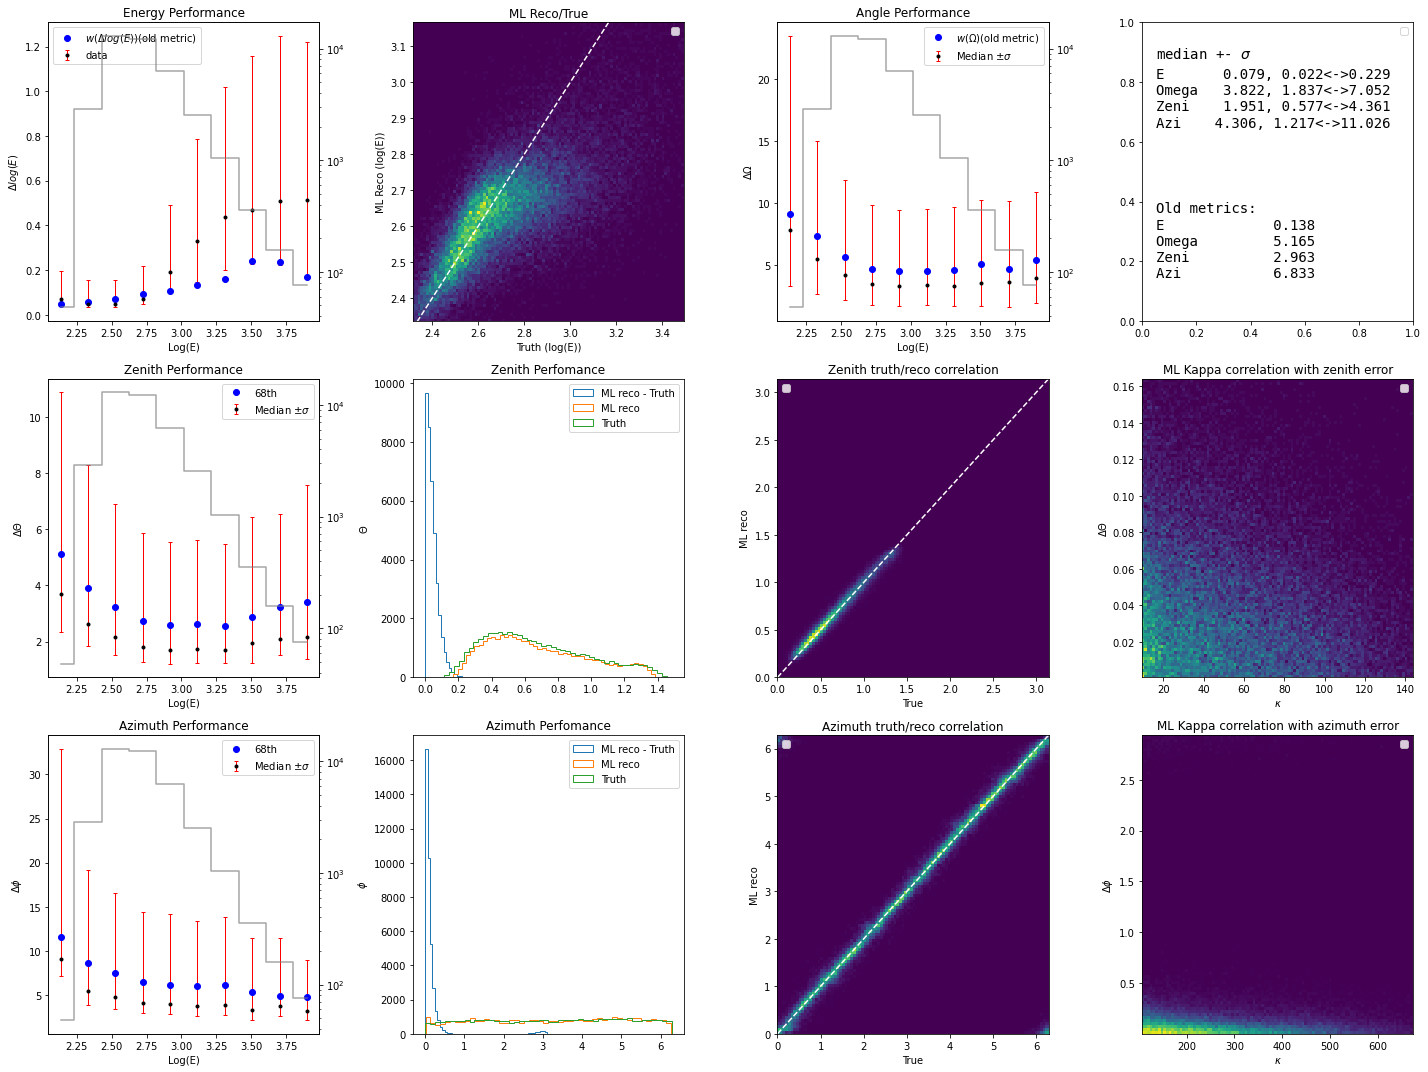

In [96]:
import model_eval.eval_plots as e
reload(e)
performance=e.performance_vM2D
performance(reco1, true1);
# performance(reco, true);